# Superposed Epoch Analysis CMIP6 Historical model runs
- opens all the C20C (20th century reanalysis data) files with data on precipitation prate and surface temperature tmax
- calculates monthly anomalies (based on 5-yr climatology) for 4 spatial regions (global, SH, Aus, E Aus) and 5 eruptions
- calculates percentiles (10, 90) to show model spread
- superposes the time-series for 5 eruptions plus mmm for tas and pr and different regions (superposed epoch analysis)

In [2]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import seaborn as sns

In [3]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [4]:
# read in precipitation data
ds_prate = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/prate/*.nc', combine='by_coords', chunks={'time': 12})

In [5]:
# read in temperature data
ds_tmax = xr.open_mfdataset('/g/data/ua8/C20C/v3/mean_daily/tmax_2m/*.nc', combine='by_coords', chunks={'time': 12})

In [6]:
# combine precipitation and temperature into one dataset
C20C = xr.Dataset({'tmax': ds_tmax.tmax, 'prate': ds_prate.prate})
# change the pr units
C20C['prate'] = C20C.prate*86400

In [7]:
# select out the same time period as the models
C20C = C20C.sel(time=slice('1850-01', '2015-01'))

## Area weighting and land frac

In [8]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/ua8/C20C/v3/LAND.nc')
landmask = landfrac_ds.mean(dim='time')

In [9]:
landmask.LAND

<xarray.DataArray 'LAND' (lat: 256, lon: 512)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46

In [10]:
# area weighting 
C20C_w = C20C*np.cos(C20C.lat*(np.pi/180))

## Group the data by month

In [11]:
# group the data by month (take the monthly mean)
C20C_mon = C20C_w.resample(time='M').mean(dim='time')

In [12]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [13]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [14]:
# eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [15]:
# select out the 10 year time frame around each eruption (5yrs before and after)
# tas
Krakatau = C20C_mon.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = C20C_mon.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = C20C_mon.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = C20C_mon.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = C20C_mon.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

# landmask not on same grid as data and so not working

## Anomalies

In [16]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

In [17]:
# store all eruptions in one array
composite_mon_Glob = funcM.reset_time(K_mon_anom_Glob, S_mon_anom_Glob, A_mon_anom_Glob, E_mon_anom_Glob, P_mon_anom_Glob, volcanoes)

In [18]:
# select out each region
composite_mon_SH = composite_mon_Glob.sel(lat=slice(-90,0))
composite_mon_Aus = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(110,160))#.where(landmask.data==1, drop=True)
composite_mon_EA = composite_mon_Glob.sel(lat=slice(-50,-10), lon=slice(140,155))#.where(landmask.data==1, drop=True)

## Mean and percentiles

In [19]:
# # calculate the monthly model mean for monthly anomalies
# composite_mmm_Glob = composite_mon_Glob.mean(dim='model').mean(dim=('lat','lon'))
# composite_mmm_SH = composite_mon_SH.mean(dim='model').mean(dim=('lat','lon'))
# composite_mmm_Aus = composite_mon_Aus.mean(dim='model').mean(dim=('lat','lon'))
# composite_mmm_EA = composite_mon_EA.mean(dim='model').mean(dim=('lat','lon'))

In [20]:
# calcuate the lat lon mean (llm) to use for calculating percentiles
composite_llm_Glob = composite_mon_Glob.mean(dim=('lat','lon'))
composite_llm_SH = composite_mon_SH.mean(dim=('lat','lon'))
composite_llm_Aus = composite_mon_Aus.mean(dim=('lat','lon'))
composite_llm_EA = composite_mon_EA.mean(dim=('lat','lon'))

In [21]:
# # calculate percentile
# # 10th percentile
# p10_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
# p10_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
# p10_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])
# p10_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.1, dim=['model', 'volcano'])

# # 90th percentile
# p90_Glob = composite_llm_Glob.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
# p90_SH = composite_llm_SH.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
# p90_Aus = composite_llm_Aus.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])
# p90_EA = composite_llm_EA.chunk({'model': -1,'volcano': -1}).quantile(0.9, dim=['model', 'volcano'])

In [22]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_llm_Glob.mean(dim='volcano')
V_composite_mmm_SH = composite_llm_SH.mean(dim='volcano')
V_composite_mmm_Aus = composite_llm_Aus.mean(dim='volcano')
V_composite_mmm_EA = composite_llm_EA.mean(dim='volcano')

In [23]:
# calculate the minimum value of the mmm for each spatial region
composite_min_mmm_Glob = V_composite_mmm_Glob.min()
composite_min_mmm_SH = V_composite_mmm_SH.min()
composite_min_mmm_Aus = V_composite_mmm_Aus.min()
composite_min_mmm_EA = V_composite_mmm_EA.min()

In [44]:
# print minimum values for composite as calculated above
print('Minimum value of composite temperature signal on each spatial scale is:\n Global:', 
      composite_min_mmm_Glob.tmax.values.round(decimals=2), '\n SH:', 
      composite_min_mmm_SH.tmax.values.round(decimals=2), '\n Aus:', 
      composite_min_mmm_Aus.tmax.values.round(decimals=2), '\n EA:', 
      composite_min_mmm_EA.tmax.values.round(decimals=2))
print('Minimum value of composite precipitation signal on each spatial scale is:\n Global:', 
      composite_min_mmm_Glob.prate.values.round(decimals=2), '\n SH:', 
      composite_min_mmm_SH.prate.values.round(decimals=2), '\n Aus:', 
      composite_min_mmm_Aus.prate.values.round(decimals=2), '\n EA:', 
      composite_min_mmm_EA.prate.values.round(decimals=2))

Minimum value of composite temperature signal on each spatial scale is:
 Global: -0.16 
 SH: -0.13 
 Aus: -0.42 
 EA: -0.46
Minimum value of composite precipitation signal on each spatial scale is:
 Global: -0.05 
 SH: -0.07 
 Aus: -0.5 
 EA: -0.61


In [45]:
# calculate the minimum value for Krakatoa in each spatial region
K_min_mmm_Glob = composite_llm_Glob.sel(volcano='Krakatau').min()
K_min_mmm_SH = composite_llm_SH.sel(volcano='Krakatau').min()
K_min_mmm_Aus = composite_llm_Aus.sel(volcano='Krakatau').min()
K_min_mmm_EA = composite_llm_EA.sel(volcano='Krakatau').min()

In [47]:
# print minimum values for Krakatoa as calculated above
print('Minimum value of composite temperature signal on each spatial scale is:\n Global:', 
      K_min_mmm_Glob.tmax.values.round(decimals=2), '\n SH:', 
      K_min_mmm_SH.tmax.values.round(decimals=2), '\n Aus:', 
      K_min_mmm_Aus.tmax.values.round(decimals=2), '\n EA:', 
      K_min_mmm_EA.tmax.values.round(decimals=2))
print('Minimum value of composite precipitation signal on each spatial scale is:\n Global:', 
      K_min_mmm_Glob.prate.values.round(decimals=2), '\n SH:', 
      K_min_mmm_SH.prate.values.round(decimals=2), '\n Aus:', 
      K_min_mmm_Aus.prate.values.round(decimals=2), '\n EA:', 
      K_min_mmm_EA.prate.values.round(decimals=2))

Minimum value of composite temperature signal on each spatial scale is:
 Global: -0.29 
 SH: -0.29 
 Aus: -0.83 
 EA: -0.95
Minimum value of composite precipitation signal on each spatial scale is:
 Global: -0.08 
 SH: -0.15 
 Aus: -1.25 
 EA: -1.5


# Figures

In [24]:
blues = sns.color_palette("Blues_r")
greens = sns.color_palette("Greens_r")
reds = sns.color_palette("Reds_r")

In [25]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

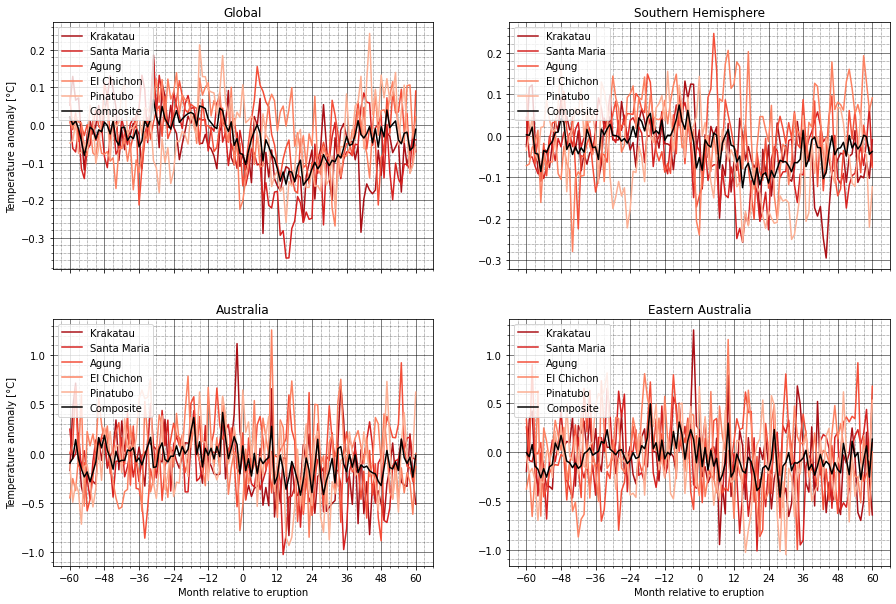

In [27]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
fplot.SEA_plots(composite_llm_Glob.tmax, V_composite_mmm_Glob.tmax, reds, ax = axes[0,0])
fplot.SEA_plots(composite_llm_SH.tmax, V_composite_mmm_SH.tmax, reds, ax = axes[0,1])
fplot.SEA_plots(composite_llm_Aus.tmax, V_composite_mmm_Aus.tmax, reds, ax = axes[1,0])
fplot.SEA_plots(composite_llm_EA.tmax, V_composite_mmm_EA.tmax, reds, ax = axes[1,1])

# set axis labels and subplot titles
axes[0,0].set(ylabel = f'Temperature anomaly [{deg}C]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(xlabel = 'Month relative to eruption', ylabel = f'Temperature anomaly [{deg}C]', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('R_SEA_mon_tmax.png', dpi=300, bbox_inches='tight')

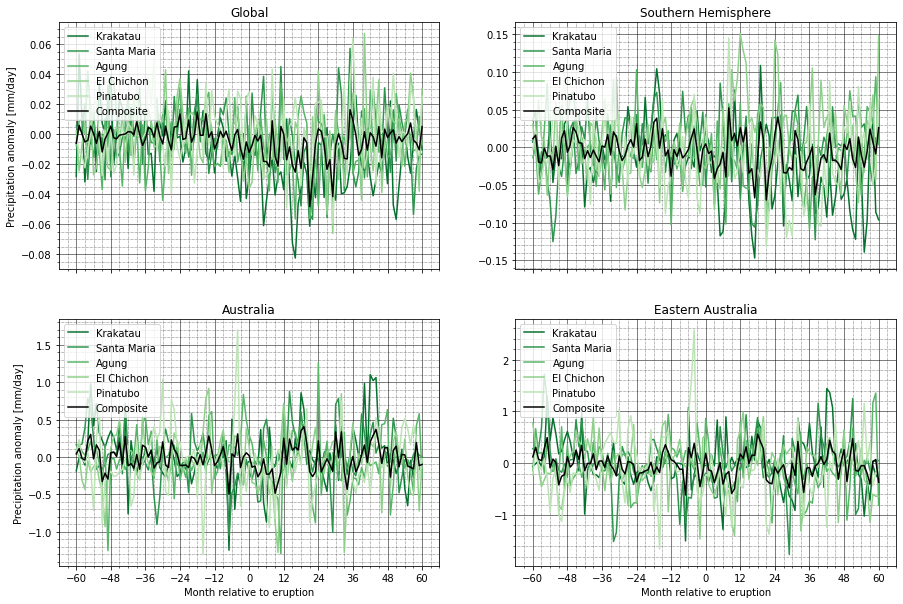

In [28]:
# plot monthly anomalies of precipitation as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10))

# make subplots for each region
fplot.SEA_plots(composite_llm_Glob.prate, V_composite_mmm_Glob.prate,  greens, ax = axes[0,0])
fplot.SEA_plots(composite_llm_SH.prate, V_composite_mmm_SH.prate, greens, ax = axes[0,1])
fplot.SEA_plots(composite_llm_Aus.prate, V_composite_mmm_Aus.prate, greens, ax = axes[1,0])
fplot.SEA_plots(composite_llm_EA.prate, V_composite_mmm_EA.prate, greens, ax = axes[1,1])

#axes[0,0].set_xticks(np.arange(min(composite_mmm_Glob.time), max(composite_mmm_Glob.time)+1, 12))

# set axis labels and subplot titles
axes[0,0].set(ylabel = 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel = 'Precipitation anomaly [mm/day]', xlabel = 'Month relative to eruption', title = 'Australia')
axes[1,1].set(xlabel = 'Month relative to eruption', title = 'Eastern Australia')

#fig.tight_layout() # if I include this line then titles overlap

plt.savefig('R_SEA_mon_prate.png', dpi=300, bbox_inches='tight')